In [1]:
#モジュールのインポート
import random, yaml
import torch, torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from random import seed, sample
from sklearn.metrics import classification_report
from torchvision import datasets, models, transforms
from utils.utils import *
from utils.models import finetune_alexnet, finetune_resnet18

### 学習関数の実装

In [19]:
def do_train(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるかを確認
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net) # make parallel

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    
    # 学習結果を保存するlist
    train_loss_list, train_acc_list =  [], []
    val_loss_list, val_acc_list =  [], []
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # モデルを学習モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_acc = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()
                
                # Test-Time Augmentation
                # img : (batch_size*crop_num, channel, height, width)
                
                if phase == 'val':
                    batch_size, crop_num, c, h, w = inputs.size()
                    inputs = inputs.view(-1, c, h, w)
                

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    # Test-Time Augmentation
                    # crop_numで平均化
                    if phase == 'val':
                        outputs = outputs.view(batch_size, crop_num, -1).mean(1)        
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_acc += sum(preds == labels.data).item()

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_acc / len(dataloaders_dict[phase].dataset)
            
            # 学習結果を保存
            if phase == 'train':
                train_loss_list.append(epoch_loss), train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss), val_acc_list.append(epoch_acc)
                
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    # PyTorchのネットワークパラメータの保存
    save_path = config["MODEL"]["SAVE_WEIGHT"]
    torch.save(net.state_dict(), save_path)
    
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

### 学習の実行

In [20]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
#グローバル変数の初期化
with open('./config.yaml') as f:
    config = yaml.load(f)
    
dataloaders_dict = make_dataLoader() #trainとvalのデータ整形
    
net,optimizer = finetune_resnet18()
criterion = nn.CrossEntropyLoss()  # 損失関数の設定
# 学習・検証を実行する
num_epochs = config["MODEL"]["EPOCH"]
train_loss_list, train_acc_list, val_loss_list, val_acc_list = do_train(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/1 [00:00<?, ?it/s]

学習済みのパラメータをロードし、訓練モードに設定完了
学習しない： conv1.weight
fine_tuning設定完了
学習しない： bn1.weight
fine_tuning設定完了
学習しない： bn1.bias
fine_tuning設定完了
params_to_update_1に格納： layer1.0.conv1.weight
fine_tuning設定完了
params_to_update_1に格納： layer1.0.bn1.weight
fine_tuning設定完了
params_to_update_1に格納： layer1.0.bn1.bias
fine_tuning設定完了
params_to_update_1に格納： layer1.0.conv2.weight
fine_tuning設定完了
params_to_update_1に格納： layer1.0.bn2.weight
fine_tuning設定完了
params_to_update_1に格納： layer1.0.bn2.bias
fine_tuning設定完了
学習しない： layer1.1.conv1.weight
fine_tuning設定完了
学習しない： layer1.1.bn1.weight
fine_tuning設定完了
学習しない： layer1.1.bn1.bias
fine_tuning設定完了
学習しない： layer1.1.conv2.weight
fine_tuning設定完了
学習しない： layer1.1.bn2.weight
fine_tuning設定完了
学習しない： layer1.1.bn2.bias
fine_tuning設定完了
学習しない： layer2.0.conv1.weight
fine_tuning設定完了
学習しない： layer2.0.bn1.weight
fine_tuning設定完了
学習しない： layer2.0.bn1.bias
fine_tuning設定完了
学習しない： layer2.0.conv2.weight
fine_tuning設定完了
学習しない： layer2.0.bn2.weight
fine_tuning設定完了
学習しない： layer2.0.bn2.bias
fine_tuning設定完了
学

  0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 3.8414 Acc: 0.5000
Epoch 2/2
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7402 Acc: 0.5000
inputs.size: torch.Size([2, 5, 3, 120, 120])
 after view inputs.size: torch.Size([10, 3, 120, 120])


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

val Loss: 3.7880 Acc: 0.5000


### 学習の可視化

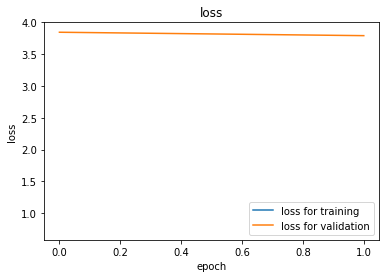

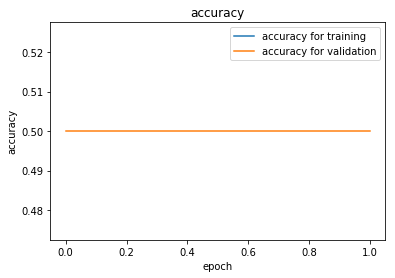

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
# 学習・検証の可視化関数
def plot_history(train_list, val_list, mode):
    plt.plot(train_list, label=f"{mode} for training")
    plt.plot(val_list, label=f"{mode} for validation")
    
    #matplotlibの細かい設定
    plt.title(f"{mode}")
    plt.xlabel("epoch")
    plt.ylabel(f"{mode}")
    plt.legend(loc='best')
    
    plt.show()    

# loss
plot_history(train_loss_list, val_loss_list, mode="loss")
# acc
plot_history(train_acc_list, val_acc_list, mode="accuracy")

In [ ]:
def do_test(dataloaders_dict):
    with open("./config.yaml") as f:
        config = yaml.load(f)
        num_classes= len(config['CLASS_NAMES'].split())
    # 以下は学習にしようするモデルによって修正する必要あり
    net = finetune_resnet18
    net.fc = nn.Linear(in_features=512, out_features=num_classes)

    net_weights = torch.load(config["MODEL"]["SAVE_WEIGHT"], map_location={'cuda': 'cpu'})
    
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in net_weights.items():
        new_state_dict[k]=v

    net.load_state_dict(new_state_dict)
    
    net.eval()
    
    Y,pred = [], []
    for inputs, labels in tqdm(dataloaders_dict["test"]):
        outputs = net(inputs)
        pred += [int(l.argmax()) for l in outputs]
        Y += [int(l) for l in labels]
    
    print(classification_report(Y, pred))
    print("outputs:", outputs)